<span style = "font-family:Geogia; color:orange;  font-style:italic; font-size:18px"> 
This is a probelm based on the "Codes with Harry" ML series.<br>
The target is to get the price of a real estate property based on the features (floor, room-count, locality... etc)<br>
This is a supervised regression problem solved using python scikit-learn. <br>
</span>
video link: https://youtu.be/iIkJrwVUl1c?si=bOpfUf7zm8093a62 <br>

The data looks like following:
$$
\begin{array}{|c|c|c|c|c|}
  \hline
  Bedroom-count & Floor & Distance\ from\ airport\ (km) & \cdot\cdot\cdot & Home\ price\ (\ crore) \\
  \hline
  2 & 12 & 10 & \cdot\cdot\cdot & 1.5 \\
  \hline
  3 & 10 & 7 & \cdot\cdot\cdot & 2.7 \\
  \hline
  1 & 2 & 1.5 & \cdot\cdot\cdot & 0.85 \\
  \hline
  \cdot\cdot\cdot & \cdot\cdot\cdot & \cdot\cdot\cdot & \cdot\cdot\cdot & \cdot\cdot\cdot \\
  \hline
  5 & 20 & 20 & \cdot\cdot\cdot & 7.6 \\
  \hline
\end{array}
$$
<!-- </span> -->

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 22 22:18:32 2024

@author: mrsag
"""

import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from scipy.signal import fftconvolve

import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display


<span style = "font-family:Geogia; color:green;  font-style:italic; font-size:18px"> 
Defining some important functions...
</span>

In [2]:
def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index


def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal


def hist_dataframe(df, bins=10):
    # Define a list of colors for each histogram
    colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'purple', 'orange', 'black']
    # Create subplots with a dynamic number of rows, 3 columns per row
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / 3)), ncols=3, figsize=(18, 4.5*int(np.ceil(len(df.columns) / 3))))
    # Flatten the axes array for easy iteration (even if it's a 2D grid)
    axes = axes.flatten()
    
    # Plot each histogram individually
    for i, column in enumerate(df.columns):
        df[column].plot(kind='hist', ax=axes[i], color=colors[i%len(colors)], title=column, bins = bins)
        axes[i].grid(True, linewidth=0.5, color='k')  # Optional: add grid
    
    # Turn off any unused subplots (in case the number of columns is not a multiple of 3)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # Delete empty subplots
    
    plt.tight_layout()  # Adjust the layout
    plt.show()
    pass

<span style = "font-family:Georgia; color:orange;  font-size:15px; font-style:italic"> 
Fetching the housing price data based on diffirent features. <br>
Data taken from UCI machine learning datasets with the package ucimlrepo. <br>
Showing the variables of the dataset and their descriptions.
</span>

In [3]:
# fetch dataset 
real_estate_valuation = fetch_ucirepo(id=477) 
# data (as pandas dataframes) 
features = real_estate_valuation.data.features 
target = real_estate_valuation.data.targets 
data = pd.concat([features, target], axis=1)

print("Variables of housing price predictor")
real_estate_valuation.variables.head(len(real_estate_valuation.variables))

Variables of housing price predictor


,name,role,type,demographic,description,units,missing_values
0,No,ID,Integer,None,None,None,no
1,X1 transaction date,Feature,Continuous,None,"for example, 2013.250=2013 March, 2013.500=201...",None,no
2,X2 house age,Feature,Continuous,None,None,year,no
3,X3 distance to the nearest MRT station,Feature,Continuous,None,None,meter,no
4,X4 number of convenience stores,Feature,Integer,None,number of convenience stores in the living cir...,integer,no
5,X5 latitude,Feature,Continuous,None,"geographic coordinate, latitude",degree,no
6,X6 longitude,Feature,Continuous,None,"geographic coordinate, longitude",degree,no
7,Y house price of unit area,Target,Continuous,None,"10000 New Taiwan Dollar/Ping, where Ping is a ...",10000 New Taiwan Dollar/Ping,no


<span style = "font-family:Georgia; color:orange;  font-size:15px;  font-style:italic"> 
Mathematical details and span of the data features and target <br>
50% means the value under which 50% of the data value lies. It is like a percentile.
</span>

In [4]:
print("Features :")
features.describe()
# features.info()

Features :


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270


In [5]:
print("Target :")
target.describe()

Target :


,Y house price of unit area
count,414.000000
mean,37.980193
std,13.606488
min,7.600000
25%,27.700000
50%,38.450000
75%,46.600000
max,117.500000


<span style = "font-family:Georgia; color:orange;  font-size:15px; font-style:italic"> 
Plotting the histogram of the data (both features and target).
</span>

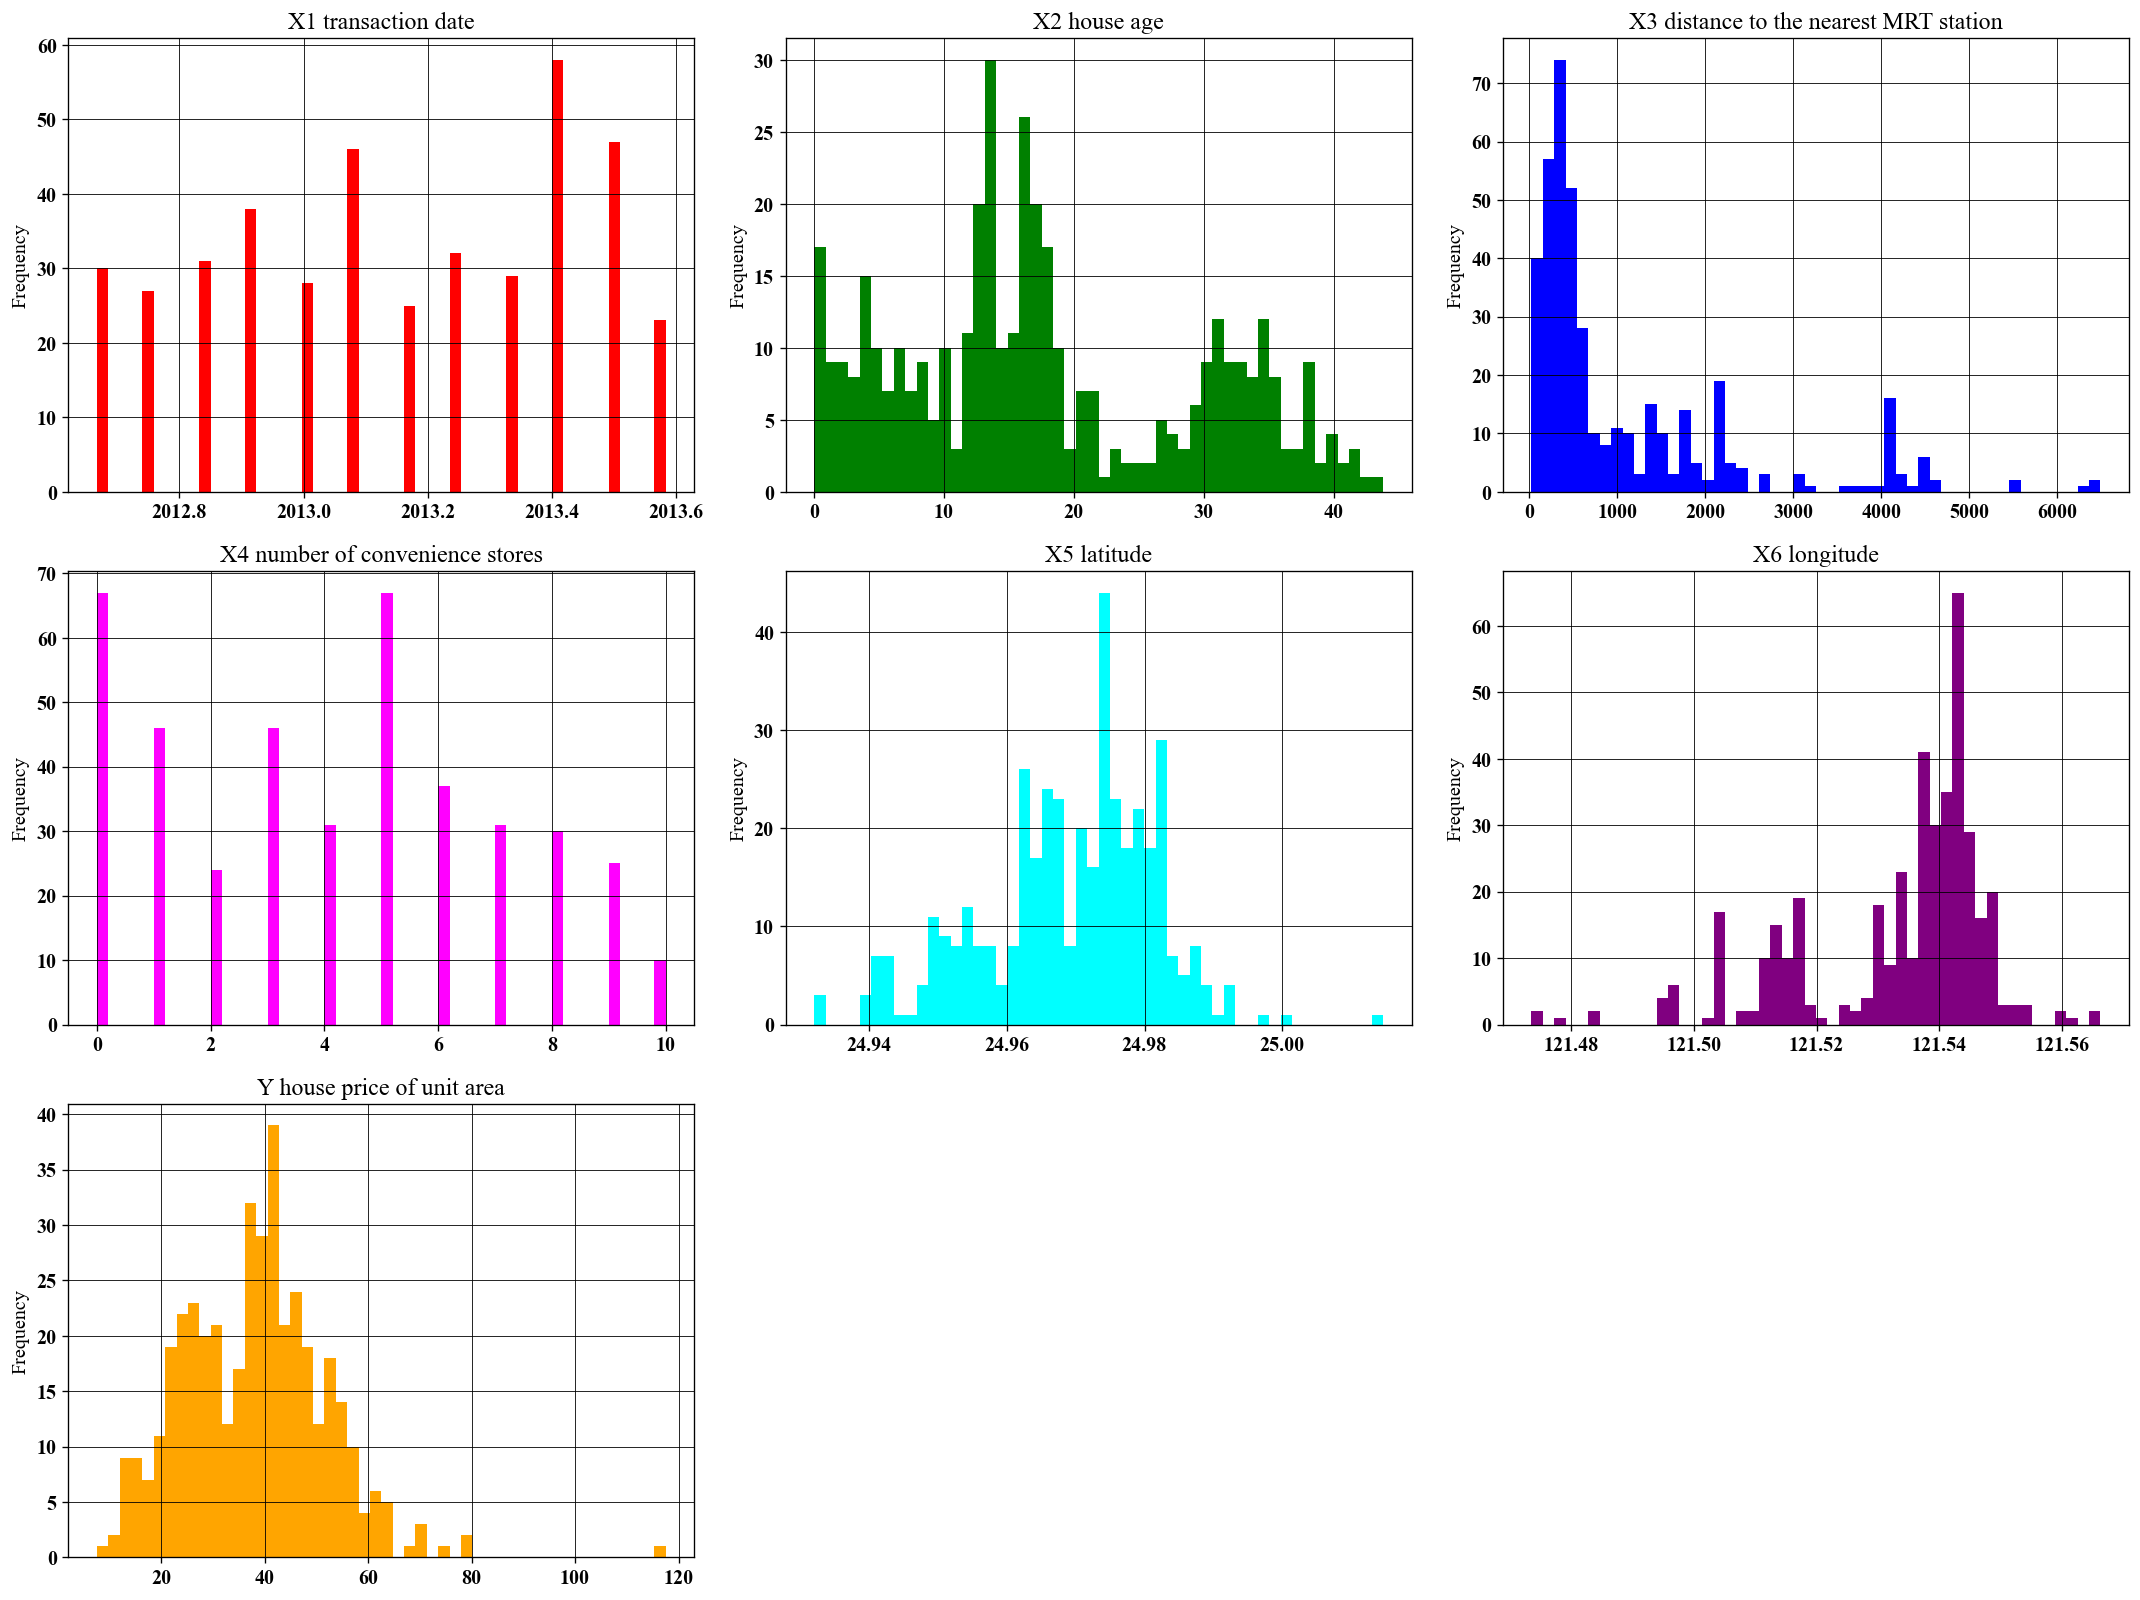

In [6]:
# data.hist(bins=50,figsize=(15,10))
hist_dataframe(data, bins = 50)

<span style = "font-family:Georgia; color:green;  font-size:12px; font-style:italic">
Showing the correlations between different features and target... <br>
The correlation shows how one parameter is varied with another. <br>
e.g. For housing data, number of rooms has a positive correlation with house price. It means, the housing price will increase with the number of rooms increasing in the house. Similarly distance from metro station will have a negative correlation with the housing data. <br>
The correlation formula is:
$$ r = \frac{n\Sigma x_iy_i-(\Sigma x_i)(\Sigma y_i)}{\sqrt{[n\Sigma x_i^2-(\Sigma x_i)^2][n\Sigma y_i^2-(\Sigma y_i)^2]}}$$
for a linear data if say: $y_i=mx_i+b$, we will get $r=\frac{m}{|m|}=\begin{cases}1 & m > 0\\-1 & m < 0\end{cases}$

for any polynomial data $y_i = ax^n$, if n is even, using $\Sigma x_i=0$ for symmetric x data along y axis, we will get for those cases of dataset, r=0. For odd n, r might not be 0.<br>
So overall, r tells how linear the relation is between x and y. And gives a basic trend. But not the exact polynomial behaviour.
</span>

In [7]:
corr_matrix = data.corr()
corr_matrix["Y house price of unit area"].sort_values(ascending=True)  # Will show the correlation value (r) between Y and diffirent x

X3 distance to the nearest MRT station   -0.673613
X2 house age                             -0.210567
X1 transaction date                       0.087491
X6 longitude                              0.523287
X5 latitude                               0.546307
X4 number of convenience stores           0.571005
Y house price of unit area                1.000000
Name: Y house price of unit area, dtype: float64

array([[<Axes: xlabel='Y house price of unit area', ylabel='Y house price of unit area'>,
        <Axes: xlabel='X2 house age', ylabel='Y house price of unit area'>,
        <Axes: xlabel='X3 distance to the nearest MRT station', ylabel='Y house price of unit area'>,
        <Axes: xlabel='X4 number of convenience stores', ylabel='Y house price of unit area'>],
       [<Axes: xlabel='Y house price of unit area', ylabel='X2 house age'>,
        <Axes: xlabel='X2 house age', ylabel='X2 house age'>,
        <Axes: xlabel='X3 distance to the nearest MRT station', ylabel='X2 house age'>,
        <Axes: xlabel='X4 number of convenience stores', ylabel='X2 house age'>],
       [<Axes: xlabel='Y house price of unit area', ylabel='X3 distance to the nearest MRT station'>,
        <Axes: xlabel='X2 house age', ylabel='X3 distance to the nearest MRT station'>,
        <Axes: xlabel='X3 distance to the nearest MRT station', ylabel='X3 distance to the nearest MRT station'>,
        <Axes: xlabel='X

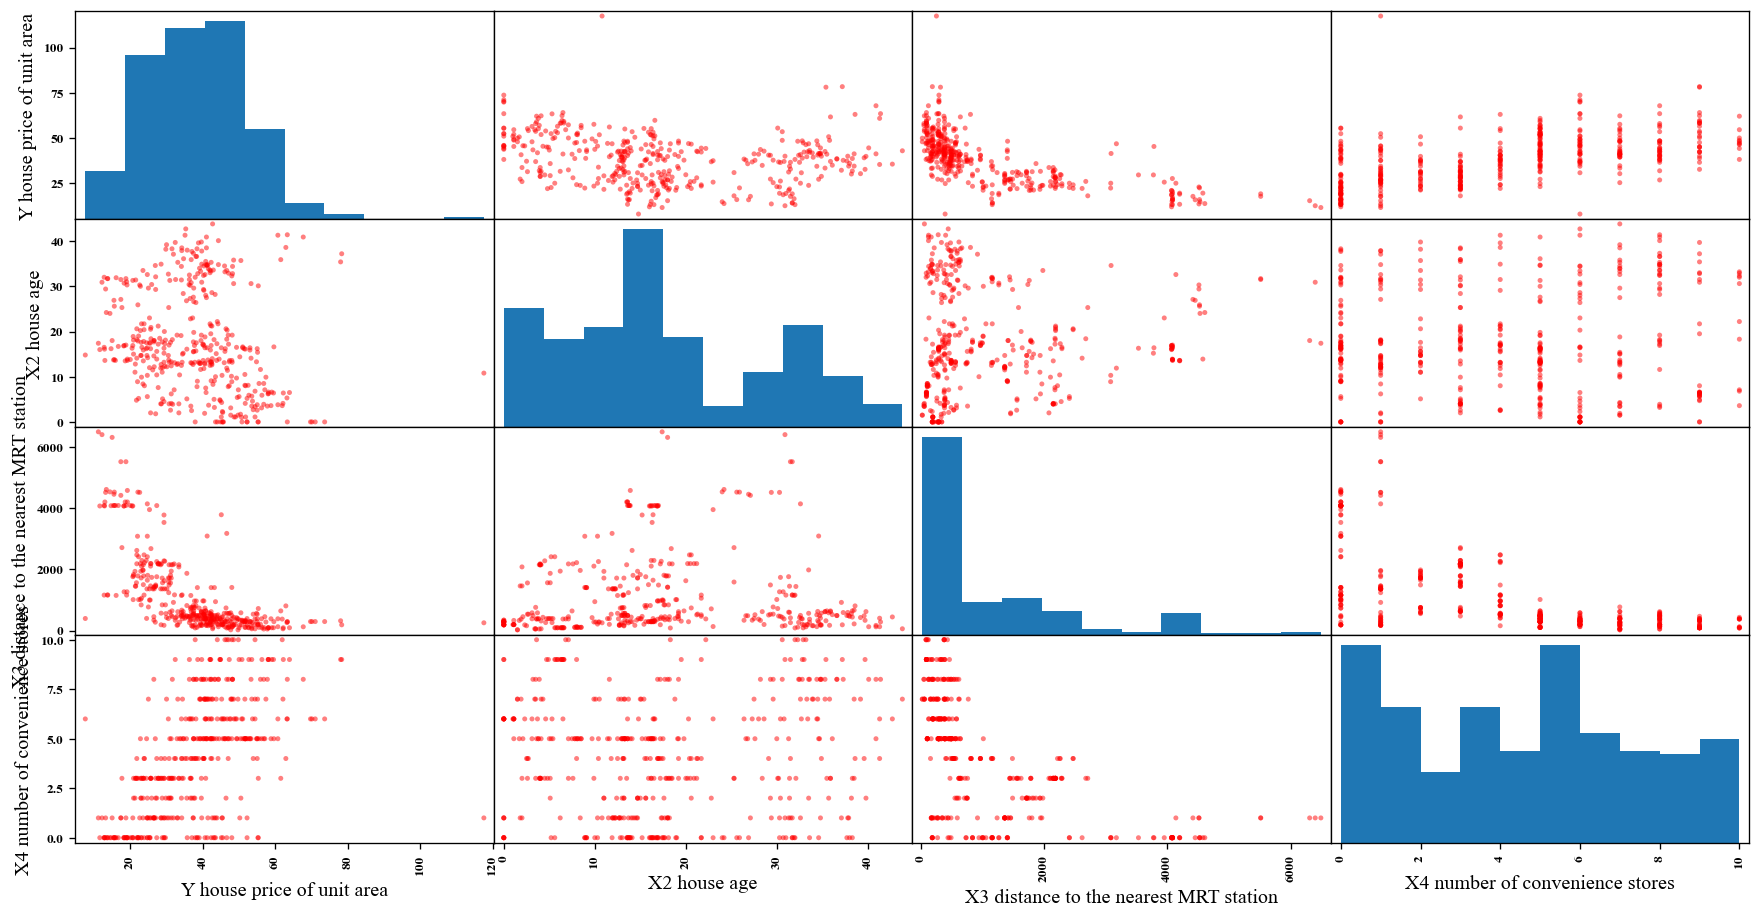

In [8]:
""" Scatter Plotting different data entities to see the correlation strength..."""
from pandas.plotting import scatter_matrix

attributes = []
attributes = ["Y house price of unit area","X2 house age","X3 distance to the nearest MRT station","X4 number of convenience stores"]
# for attr in data.columns:    # to plot between all features and target.
#     attributes.append(attr)

scatter_matrix(data[attributes], figsize=(18,9), alpha=0.5, color='r')

<span style = "font-family:Georgia; color:orange;  font-size:15px;  font-style:italic">
We can also combine multiple features in a single attribute and see the combined outcome...<br>
Here say we want to combine distance from metro stn and no of stores and see the outcome.
</span>

In [22]:
""" Say we create a new attribute named local_facility = no_of_stores + 5000/distance_to_metro_stn(meter)
    (the reason to divide metro distance by 5000 is to add two quantities of same order. generally no_of_store ~ 4 & metro_distance ~ 1000.
    So by dividing we will get local_facillity ~ 5 + 5000/1000 = 5+5 = 10.)
    
    As the no of stores will increase or distance to metro will decrease, we will get better local_facility value. """

data["X7 local_facility"] = data["X4 number of convenience stores"]+5000/data["X3 distance to the nearest MRT station"]
corr_matrix = data.corr()
print("""Lets see the correlation between this new entity (local_facility) with the house price
________________________________________________________________________________________""")
corr_matrix["Y house price of unit area"].sort_values(ascending=True)  # This will also show the correlation between price and facility

Lets see the correlation between this new entity (local_facility) with the house price
________________________________________________________________________________________


X3 distance to the nearest MRT station   -0.673613
X2 house age                             -0.210567
X1 transaction date                       0.087491
X7 local_facility                         0.499706
X6 longitude                              0.523287
X5 latitude                               0.546307
X4 number of convenience stores           0.571005
Y house price of unit area                1.000000
Name: Y house price of unit area, dtype: float64

Lets see the scatterplot between this new entity (local_facility) with the house price
________________________________________________________________________________________


<Axes: xlabel='X7 local_facility', ylabel='Y house price of unit area'>

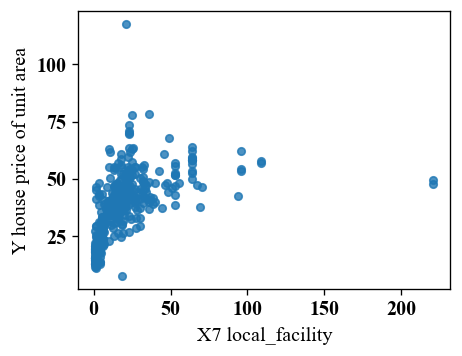

In [26]:
print("""Lets see the scatterplot between this new entity (local_facility) with the house price
________________________________________________________________________________________""")
data.plot(kind="scatter", x="X7 local_facility", y="Y house price of unit area", alpha = 0.8, figsize = (4,3))

<span style = "font-family:Georgia; color:orange;  font-size:15px;  font-style:italic"> 
We define a function to create separate train and test data set. The train data is taken out randomly from the dataset and not
the given ordered data (if ordering is already done) to make the model stronger.<br>
The percentage has to be given to the function along with the data. <br>
The retuen will be separated out train and test data.
</span>

<span style = "font-family:Georgia; color:red;  font-size:15px;  text-decoration:underline">
important note :<br>
</span>

<span style = "font-family:Georgia; color:green;  font-size:12px">
If some features is very important but very much skewed, the random shuffling may not distribute the data equally in train and test set. <br>
e.g. all over the world people have + and - blood groups with 85% + and 15% - blood. <br>
In any physiological problem, the blood group is very important variable but it's too much skewed. So in random shuffling of train:test = 90:10, the 10% test data may not have any - group blood and the model might not know there is even any blood group named '-'. <br>
To solve this probelm, there is a way to shuffling called "STRATIFIED SHUFFLING" <br>
The function is imported from:  from sklearn.model_selection import StratifiedShuffleSplit <br>
a possible use example is given in the below cell comment. <br>
for details: go https://youtu.be/iIkJrwVUl1c?si=bOpfUf7zm8093a62 at time: 1:09:00
</span>

In [9]:
""" function for random shuffling """
# def train_test_split(data,test_ratio = 0.2):
#     np.random.seed(42) # to make the shuffle constant. So that the model never sees the test data in the long run
#     shuffled = np.random.permutation(len(data))
#     test_set_size = int(len(data)*test_ratio)
#     test_indices = shuffled[0:test_set_size]
#     train_indices = shuffled[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]
""" We can take the same function from the in built scikit-learn package function..."""
from sklearn.model_selection import train_test_split


"""If we need Statified Shuffle Split, take the following one: """
from sklearn.model_selection import StratifiedShuffleSplit as ssf
# split = ssf(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(data, data["X1 transaction date"]): # if "X1 transaction date" is important variable that we need stratified split
#     train_set = data.iloc[train_index]
#     test_set = data.iloc[test_index]
# plt.hist(train_set["X1 transaction date"],bins = 20,label="train set")
# plt.hist(test_set["X1 transaction date"],bins = 20, label="test set")   # this histogram shows that population is evenly distributed for "X1 transaction date"
# plt.show()

In [10]:
train_set,test_set = train_test_split(data, test_size = 0.2, random_state = 42)

<span style = "font-family:Georgia; color:orange;  font-size:15px; font-style:italic"> 
splitting the train and test data into features and target subparts
</span>

In [11]:
train_features = train_set.iloc[:,:-1]
train_target = train_set.iloc[:,-1]

test_features = test_set.iloc[:,:-1]
test_target = test_set.iloc[:,-1]

print(f"{len(train_set)} , {len(test_set)}")
# test_set.head(len(test_set))   # to run repeatadely to see if the split is constant...

331 , 83
